
## Species Distribution Modeling: Ensemble Climate Projections for Southwestern Deserts

*How can models of climate change effects on geographic distributions incorporate symbiotic species relationships? What is the best quantification of uncertainty for climate forecasts in Southwestern deserts?*

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

Scripts for reproducing analyses presented at SICB 2021 and SCCUR 2019 conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Comparing ML Classifiers with PyCaret and SKlearn
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality (coefficient of variation)| n/a
|BioClim18| Precip Warmest Quarter | mm
|BioClim19| Precip Coldest Quareter| mm
|BioClim3| Isothermality | $^o$C*100
|BioClim6| Min Temp Coldest Month| $^o$C
|BioClim7| Temp Annual Range| $^o$C
|BioClim8| Mean Temp Wettest Quareter | $^o$C
|BioClim9| Mean Temp Driest Quareter | $^o$C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

---
 
Binary classification is performed with ten BioClim features, five of which are a function of precipitation and five of temperature. The features were decorrelated below a 0.5 correlation threshold through jacknife resample testing. We use PyCaret to train and tune (10-fold cv) our models from a train set that contains 80% of the total data. Raster processing, data extraction, train/test splitting, as well as data piping to .csv and geojson were performed in R.

---

In [2]:
exec(open('ML_sdms_train.py').read())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9604,0.9894,0.9510,0.9610,0.9606,0.8946,0.8949,0.3800
lightgbm,Light Gradient Boosting Machine,0.9599,0.9894,0.9510,0.9607,0.9601,0.8934,0.8939,0.0630
xgboost,Extreme Gradient Boosting,0.9591,0.9878,0.9505,0.9599,0.9593,0.8913,0.8918,0.3000
et,Extra Trees Classifier,0.9588,0.9903,0.9489,0.9594,0.9590,0.8903,0.8906,11.6090
catboost,CatBoost Classifier,0.9566,0.9884,0.9485,0.9578,0.9569,0.8852,0.8859,3.9600
gbc,Gradient Boosting Classifier,0.9504,0.9840,0.9367,0.9511,0.9506,0.8679,0.8683,0.2950
dt,Decision Tree Classifier,0.9426,0.9282,0.9264,0.9432,0.9428,0.8469,0.8472,0.0140
ada,Ada Boost Classifier,0.9375,0.9788,0.9197,0.9385,0.9377,0.8334,0.8342,0.1030
knn,K Neighbors Classifier,0.9356,0.9709,0.9280,0.9389,0.9365,0.8323,0.8340,0.0750
qda,Quadratic Discriminant Analysis,0.9262,0.9727,0.9305,0.9346,0.9281,0.8133,0.8187,0.0090


---

Now that we have trained and tuned our ML models, we are ready to test their validation set performance. We first print the validation F statistic and 2x2 confusion matrix and then visualize the AUC statistic with the ROC curve. A blended model was also created with the five most predictive PyCaret classifiers, which will be used for the ensemle climate projections. Lastly, we rank our models by the validation F statistic. 

---

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Fraction correct validation 5-model Blend : 0.9721175584024114
[[972  23]
 [ 14 318]]
The F1 validation score is :  0.9450222882615156


Fraction correct validation Random Forest : 0.9743782969103241
[[974  21]
 [ 13 319]]
The F1 validation score is :  0.9494047619047619


Fraction correct validation Extra Trees : 0.9713639788997739
[[973  22]
 [ 16 316]]
The F1 validation score is :  0.9432835820895522


Fraction correct validation XGBoost : 0.9691032403918614
[[970  25]
 [ 16 316]]
The F1 validation score is :  0.9390787518573551


Fraction correct validation LGBoost Machine : 0.9713639788997739
[[971  24]
 [ 14 318]]
The F1 validation score is :  0.94362017804154

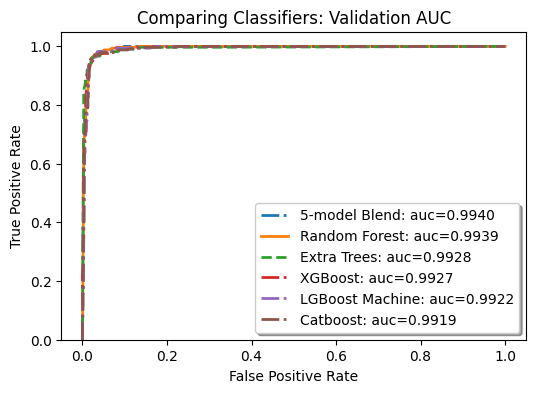

In [3]:
exec(open('ML_sdms_predict.py').read())

In [4]:
f_score # from validation set

,Random Forest,Catboost,5-model Blend,LGBoost Machine,Extra Trees,XGBoost
F-statistic :,0.949405,0.948301,0.945022,0.94362,0.943284,0.939079


### Geospatial Predictions of Species Distributions

---

We first perform spatial classification with the 5-model blended classifier. Spatial predictions were powered by the pyimpute library, see my [contributions](https://github.com/perrygeo/pyimpute/pull/21) merged at version 0.2 (_main.py). We also perform a spatial blend of the five models. In the next notebook, we perform a series of climate projections with 8 unique climate models over 16 different future scenarios. 

In [5]:
# directly define edited pyimpute functions
exec(open('_main.py').read())
# or import pyimpute>=0.2
import pyimpute

In [6]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features
explanatory_rasters = sorted(glob.glob(
    '/Users/danielfurman/Data_science_code/xantusia-data-main/train_tifs/bclim*.asc'))

print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab geojson of presences/absences
response_data = gpd.GeoDataFrame.from_file(
    '/Users/danielfurman/Data_science_code/xantusia-data-main/points_xv/points_xv.shp') 
response_data.head(3) # check geojson


There are 10 .asc features.


,longitude,latitude,pa,geometry
0,-118.527201,34.798079,1.0,POINT (-118.52720 34.79808)
1,-113.778800,37.167000,1.0,POINT (-113.77880 37.16700)
2,-118.123244,35.737211,1.0,POINT (-118.12324 35.73721)


In [7]:
# create pyimpute framework with presences/absences geojson and feature rasters
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='pa') 
# train_xs.shape, train_y.shape # check shape
target_xs, raster_info = load_targets(explanatory_rasters)
blender_specific.fit(train_xs, train_y)
# spatial prediction with impute function, saves tifs to file
impute(target_xs, blender_specific, raster_info, 
       outdir="/Users/danielfurman/Data_science_code/ensemble-climate-projections", 
       class_prob=True, certainty=True)

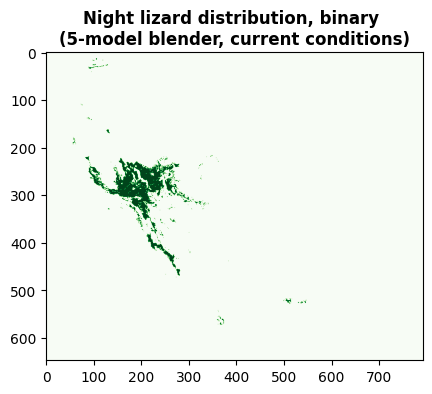

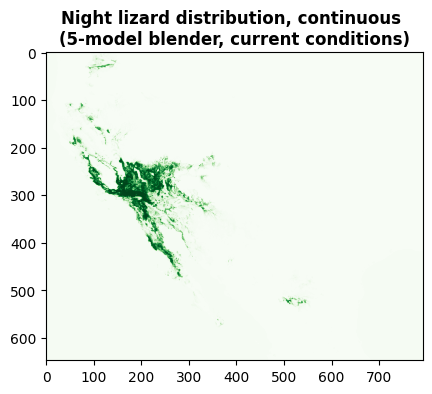

In [8]:
# plot the spatial output of the 5-model blended classifier
rf_curr = rasterio.open("responses.tif") 
plt.imshow(rf_curr.read(1), cmap='Greens')
plt.title('Night lizard distribution, binary \n(5-model blender, current conditions)',
          fontweight ='bold')
plt.figure()
rf_curr = rasterio.open("probability_1.tif") 
plt.imshow(rf_curr.read(1), cmap = 'Greens')
plt.title('Night lizard distribution, continuous \n(5-model blender, current conditions)',
          fontweight ='bold')
print('')

In [9]:
# perform spatial blend, where a pixel is suitable only where all five models are seperately in agreement
CLASS_MAP = {
    'rf': ('-', rf),
    'et': ('--', etrees),
    'xgb': ('-.', xgboost),
    'lgbm': ('-.', lgbm),
    'cb': ('-.', catboost)
    }
for name, (line_fmt, model) in CLASS_MAP.items():
    model.fit(train_xs, train_y)
    impute(target_xs, model, raster_info, 
           outdir="/Users/danielfurman/Data_science_code/ensemble-climate-projections/test/" + name,
           class_prob=True, certainty=True)

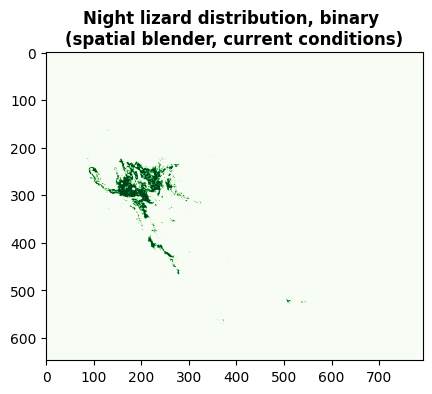

In [10]:
# load raster (overlapping performed with R's Raster package in a seperate script)
spatial_blend = rasterio.open(
    "/Users/danielfurman/Data_science_code/ensemble-climate-projections/test/spatial_blend.tif") 
plt.imshow(spatial_blend.read(1), cmap = 'Greens')
plt.title('Night lizard distribution, binary \n(spatial blender, current conditions)',
          fontweight ='bold')
print('')